In [1]:
import time
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
import math
import importlib
import matplotlib.pyplot as plt
from datetime import datetime
import re

df = pd.read_pickle('/Users/jensknudsen/Desktop/LOBSTER_DATA/PROJECT/combined/combined_depth5_time100L_window5.pkl')

import pandas as pd

first_time = ['0,01', '0,1', '0,5', '1', '5', '10']
time = ['10L', '100L', '500L', '1S', '5S', '10S']

holder_for_tickers = []

def closest_value(input):
    # Adjust the input to the closest higher multiple of 250
    return int(input + (200 - input % 200))

for i, x in zip(first_time, time):
    file_path = f'/Users/jensknudsen/Desktop/result/{i}/predictions_depth5_time{x}_window5_predicted.csv'
    label_df_new = pd.read_csv(file_path)
    
    val_procent = 0.2
    num_samples = len(label_df_new) * val_procent
    train_samples = closest_value(num_samples)

    val_df = label_df_new[:train_samples]
    test_df = label_df_new[train_samples:]

    ticker_lists = {i: [] for i in range(1, 11)}  # Clear ticker lists for each iteration

    # Group by 'Time' and process each group
    for time, group in test_df.groupby('Time'):
        # Assign deciles based on 'predicted_return'
        group['Decile'] = pd.qcut(group['predicted_return'], 10, labels=False, duplicates='drop')

        # Append tickers for each decile to respective lists
        for decile in range(10):
            ticker_lists[decile + 1].extend(group[group['Decile'] == decile]['Ticker'].values)

    # Initialize an empty DataFrame to store the ticker counts
    df_ticker = pd.DataFrame()
    
    # Combine all the ticker lists for each decile and count occurrences
    for decile, tickers in ticker_lists.items():
        # Flatten the list of tickers for the current decile
        flat_tickers = [item for item in tickers]
        # Count occurrences of each ticker
        ticker_counts = pd.Series(flat_tickers).value_counts()
        # Append the counts to the DataFrame with the decile as the column name
        df_ticker = pd.concat([df_ticker, ticker_counts.rename(f'Decile_{decile}')], axis=1)
    
    # Fill NaN values with 0 in the DataFrame
    df_ticker = df_ticker.fillna(0)

    # Sum the rows to get the total occurrences
    df_ticker['Total'] = df_ticker.sum(axis=1)
    
    # Multiply each column by its respective decile number and calculate 'Value'
    for decile in range(1, 11):
        df_ticker[f'Decile_{decile}'] = df_ticker[f'Decile_{decile}'] * decile

    # Calculate the 'Value' column
    df_ticker['Value'] = df_ticker[[f'Decile_{decile}' for decile in range(1, 11)]].sum(axis=1) / df_ticker['Total']
    
    # Sort by 'Value' in ascending order
    df_ticker = df_ticker.sort_values(by='Value', ascending=True)

    # Append the Value column to the holder_for_tickers list
    holder_for_tickers.append(df_ticker['Value'])

# use the holder_for_tickers to make a dataframe
holder_for_tickers = pd.DataFrame(holder_for_tickers)
holder_for_tickers = holder_for_tickers.T
# rename the columns
holder_for_tickers.columns = ['0,01', '0,1', '0,5', '1', '5', '10']


In [2]:

# select only the top 10 for each column in holder_for_tickers
top_10_tickers_10L = holder_for_tickers.nlargest(10, '0,01').iloc[:, 0]
top_10_tickers_100L = holder_for_tickers.nlargest(10, '0,1').iloc[:, 1]
top_10_tickers_500L = holder_for_tickers.nlargest(10, '0,5').iloc[:, 2]
top_10_tickers_1S = holder_for_tickers.nlargest(10, '1').iloc[:, 3]
top_10_tickers_5S = holder_for_tickers.nlargest(10, '5').iloc[:, 4]
top_10_tickers_10S = holder_for_tickers.nlargest(10, '10').iloc[:, 5]

# select only the top 10 buttons for each column in holder_for_tickers
bottom_10_tickers_10L = holder_for_tickers.nsmallest(10, '0,01').iloc[:, 0]
bottom_10_tickers_100L = holder_for_tickers.nsmallest(10, '0,1').iloc[:, 1]
bottom_10_tickers_500L = holder_for_tickers.nsmallest(10, '0,5').iloc[:, 2]
bottom_10_tickers_1S = holder_for_tickers.nsmallest(10, '1').iloc[:, 3]
bottom_10_tickers_5S = holder_for_tickers.nsmallest(10, '5').iloc[:, 4]
bottom_10_tickers_10S = holder_for_tickers.nsmallest(10, '10').iloc[:, 5]

# make a dataframe with the top 10 tickers for each time
top_10_tickers = pd.concat([top_10_tickers_10L, top_10_tickers_100L, top_10_tickers_500L, top_10_tickers_1S, top_10_tickers_5S, top_10_tickers_10S], axis=1)
top_10_tickers.columns = ['10L', '100L', '500L', '1S', '5S', '10S']

# make a dataframe with the bottom 10 tickers for each time
bottom_10_tickers = pd.concat([bottom_10_tickers_10L, bottom_10_tickers_100L, bottom_10_tickers_500L, bottom_10_tickers_1S, bottom_10_tickers_5S, bottom_10_tickers_10S], axis=1)
bottom_10_tickers.columns = ['10L', '100L', '500L', '1S', '5S', '10S']

top_10_tickers = top_10_tickers.T
top_10_tickers

bottom_10_tickers = bottom_10_tickers.T
bottom_10_tickers

# Count NaN values for each column
na_counts = top_10_tickers.isna().sum()

# Sort columns by NaN counts
sorted_columns = na_counts.sort_values().index
sorted_top_10_tickers = top_10_tickers[sorted_columns]

# Sort each column individually by values
#for col in sorted_top_10_tickers.columns:
#    sorted_top_10_tickers[col] = sorted_top_10_tickers[col].sort_values(ascending=False).values

sorted_top_10_tickers
# Flip the DataFrame columns such that the first column becomes the last, the second becomes the second last, and so on
flipped_top_10_tickers = sorted_top_10_tickers[sorted_top_10_tickers.columns[::-1]]
flipped_top_10_tickers

na_counts = bottom_10_tickers.isna().sum()

# Sort columns by NaN counts
sorted_columns = na_counts.sort_values().index
sorted_bottom_10_tickers = bottom_10_tickers[sorted_columns]

# Sort each column individually by values
#for col in sorted_bottom_10_tickers.columns:
#   sorted_bottom_10_tickers[col] = sorted_bottom_10_tickers[col].sort_values(ascending=False).values

sorted_bottom_10_tickers
# Flip the DataFrame columns such that the first column becomes the last, the second becomes the second last, and so on
flipped_bottom_10_tickers = sorted_bottom_10_tickers[sorted_bottom_10_tickers.columns[::-1]]

flipped_bottom_10_tickers
flipped_top_10_tickers

,ABNB,CVS,AAPL,MCHP,MO,SHOP,BABA,KHC,GOOGL,OXY,...,JPM,TMUS,CVX,AMAT,EOG,NVDA,META,MSFT,AMD,TSLA
10L,NaN,7.83694,7.815079,7.794111,7.790319,7.7147,NaN,7.882891,7.874414,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.830248,8.063350,8.323444
100L,NaN,NaN,NaN,NaN,NaN,NaN,8.76489,NaN,NaN,8.37408,...,8.516841,8.476021,NaN,8.405532,NaN,8.539371,8.531118,9.238456,8.823556,9.646888
500L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,8.582199,8.709569,NaN,9.087441,9.259648,9.339059,9.090118,8.734553,9.542717
1S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.674325,8.507473,NaN,8.670087,8.911889,9.317198,9.143654,9.266116,8.761767,9.370957
5S,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.669195,7.903859,7.785858,8.294223,8.195851,8.243587,7.939326,8.434307
10S,7.510952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,7.455521,7.578006,7.743853,8.013411,7.938310,8.041574,7.641484,8.165847


In [52]:

def plot_ticker_values_combined_higher(df):
    fig, ax = plt.subplots(figsize=(15, 10))

    time_windows = df.index
    colors = plt.cm.viridis(np.linspace(0, 1, len(time_windows)))
    bar_width = 0.12  # Width of each bar
    y_positions = np.arange(len(df.columns))  # Position of the bars on the y-axis

    # Dictionary to store combined tickers
    combined_tickers = {}

    # Collect unique tickers from top and bottom 10 of each time window
    for i, time in enumerate(time_windows):
        #sorted_values = df.loc[time].sort_values(ascending=False).dropna()
        sorted_values = df.loc[time].dropna()
        # Get top 10 and bottom 10 tickers
        top_10 = sorted_values.head(5)
        bottom_10 = sorted_values.tail(5)
        
        # Combine top 10 and bottom 10
        combined = pd.concat([top_10, bottom_10])
        
        # Ensure unique tickers by removing duplicates and keeping the first occurrence
        combined = combined[~combined.index.duplicated(keep='first')]
        
        combined_tickers[time] = combined

    # Create a unique list of tickers that appear in any top or bottom list
    #unique_tickers = pd.Index([]).append([tickers.index for tickers in combined_tickers.values()]).unique()
    unique_tickers =df.columns
    
    # Create a mapping of tickers to their positions
    ticker_positions = {ticker: pos for pos, ticker in enumerate(unique_tickers)}

    # Plot each layer
    for i, time in enumerate(time_windows):
        values = combined_tickers[time].reindex(unique_tickers).fillna(0)
        ax.barh([ticker_positions[ticker] + i * bar_width for ticker in unique_tickers], 
                values.values, height=bar_width, color=colors[i], edgecolor='black', label=time)
        
        # Annotate bars with values
        #for j, value in enumerate(values):
        #    if value != 0:
        #        ax.text(value, ticker_positions[unique_tickers[j]] + i * bar_width, f'{value:.2f}', 
        #                va='center', ha='right', fontsize=8, color='black')

    ax.set_yticks([ticker_positions[ticker] + (len(time_windows) - 1) * bar_width / 2 for ticker in unique_tickers])
    ax.set_yticklabels(unique_tickers, fontsize=14)
    # make the x axis bigger so the values can be seen
    ax.set_xlabel('Decile', fontsize=16)
    # make the x ticks bigger
    ax.tick_params(axis='x', labelsize=14)
    #ax.set_title('Top 5 Highest Mean-Decile Values across Models', fontsize=16)
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    # make the legend bigger
    ax.legend(by_label.values(), by_label.keys(), title="Model", title_fontsize='large', fontsize='large', loc='lower right')
    
    plt.tight_layout()
    plt.show()

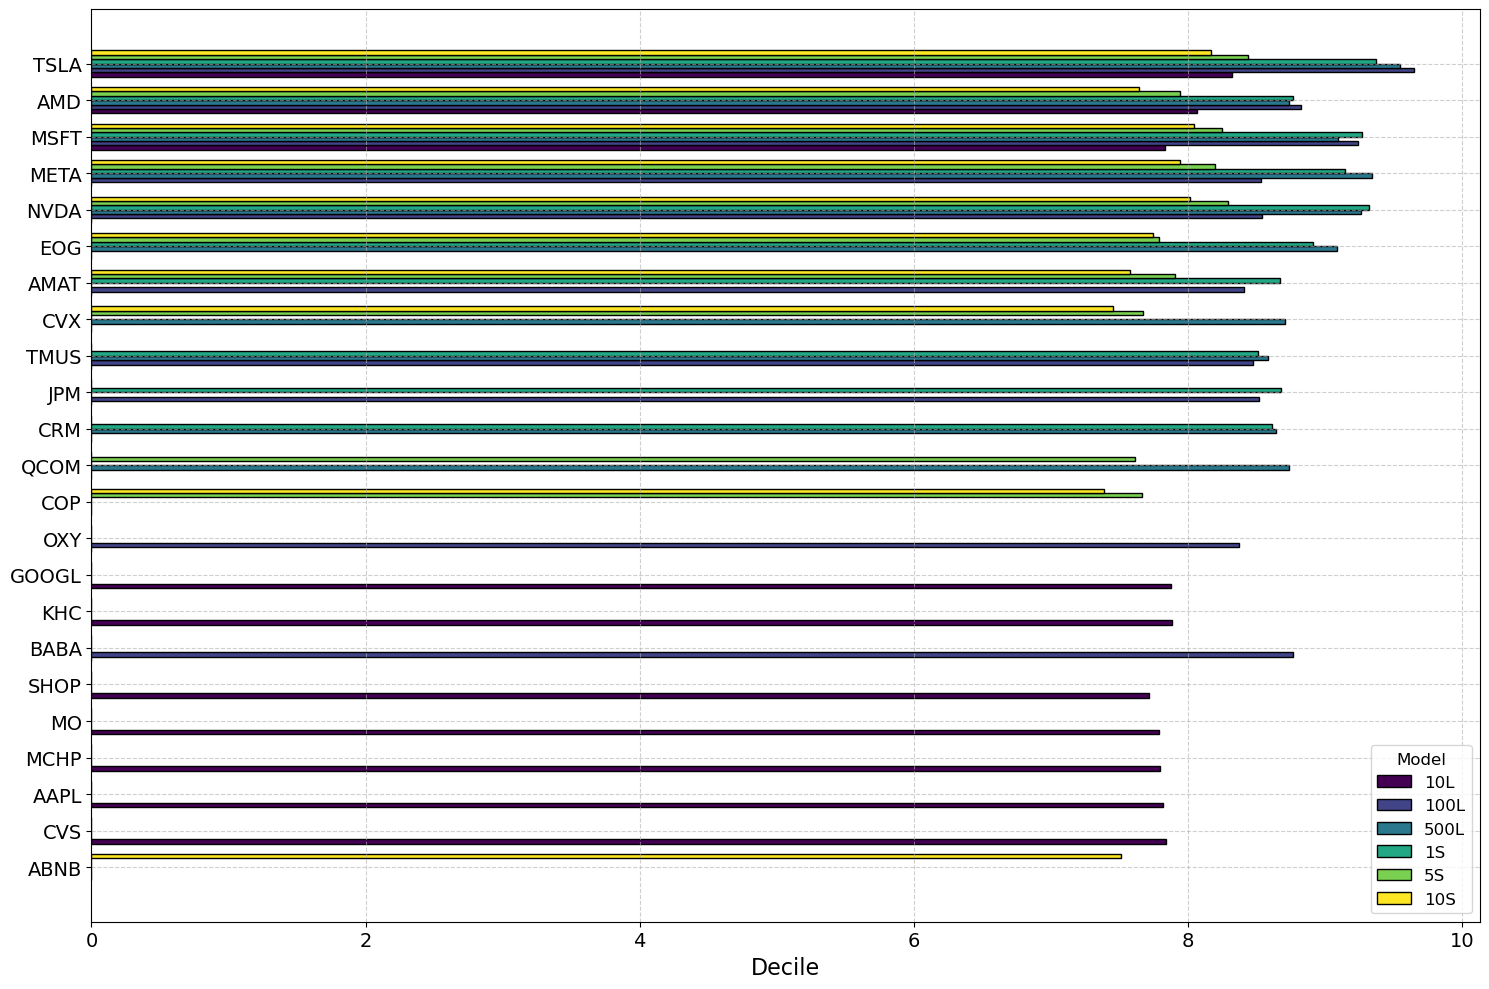

In [53]:
plot_ticker_values_combined_higher(flipped_top_10_tickers)

In [38]:
def plot_ticker_values_combined_lower(df):
    fig, ax = plt.subplots(figsize=(15, 10))

    time_windows = df.index
    colors = plt.cm.viridis(np.linspace(0, 1, len(time_windows)))
    bar_width = 0.12  # Width of each bar
    y_positions = np.arange(len(df.columns))  # Position of the bars on the y-axis

    # Dictionary to store combined tickers
    combined_tickers = {}

    # Collect unique tickers from top and bottom 10 of each time window
    for i, time in enumerate(time_windows):
        #sorted_values = df.loc[time].sort_values(ascending=False).dropna()
        sorted_values = df.loc[time].dropna()
        # Get top 10 and bottom 10 tickers
        top_10 = sorted_values.head(5)
        bottom_10 = sorted_values.tail(5)
        
        # Combine top 10 and bottom 10
        combined = pd.concat([top_10, bottom_10])
        
        # Ensure unique tickers by removing duplicates and keeping the first occurrence
        combined = combined[~combined.index.duplicated(keep='first')]
        
        combined_tickers[time] = combined

    # Create a unique list of tickers that appear in any top or bottom list
    #unique_tickers = pd.Index([]).append([tickers.index for tickers in combined_tickers.values()]).unique()
    unique_tickers =df.columns
    
    # Create a mapping of tickers to their positions
    ticker_positions = {ticker: pos for pos, ticker in enumerate(unique_tickers)}

    # Plot each layer
    for i, time in enumerate(time_windows):
        values = combined_tickers[time].reindex(unique_tickers).fillna(0)
        ax.barh([ticker_positions[ticker] + i * bar_width for ticker in unique_tickers], 
                values.values, height=bar_width, color=colors[i], edgecolor='black', label=time)
        
        #Annotate bars with values
        #for j, value in enumerate(values):
        #    if value != 0:
        #        ax.text(value, ticker_positions[unique_tickers[j]] + i * bar_width, f'{value:.2f}', 
        #                va='center', ha='right', fontsize=8, color='black')

    ax.set_yticks([ticker_positions[ticker] + (len(time_windows) - 1) * bar_width / 2 for ticker in unique_tickers])
    ax.set_yticklabels(unique_tickers, fontsize=12)
    ax.set_xlabel('Value', fontsize=14)
    #ax.set_title('Top 5 Lowest Mean-Decile Values across Models', fontsize=16)
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), title="Time Window")
    
    plt.tight_layout()
    plt.show()

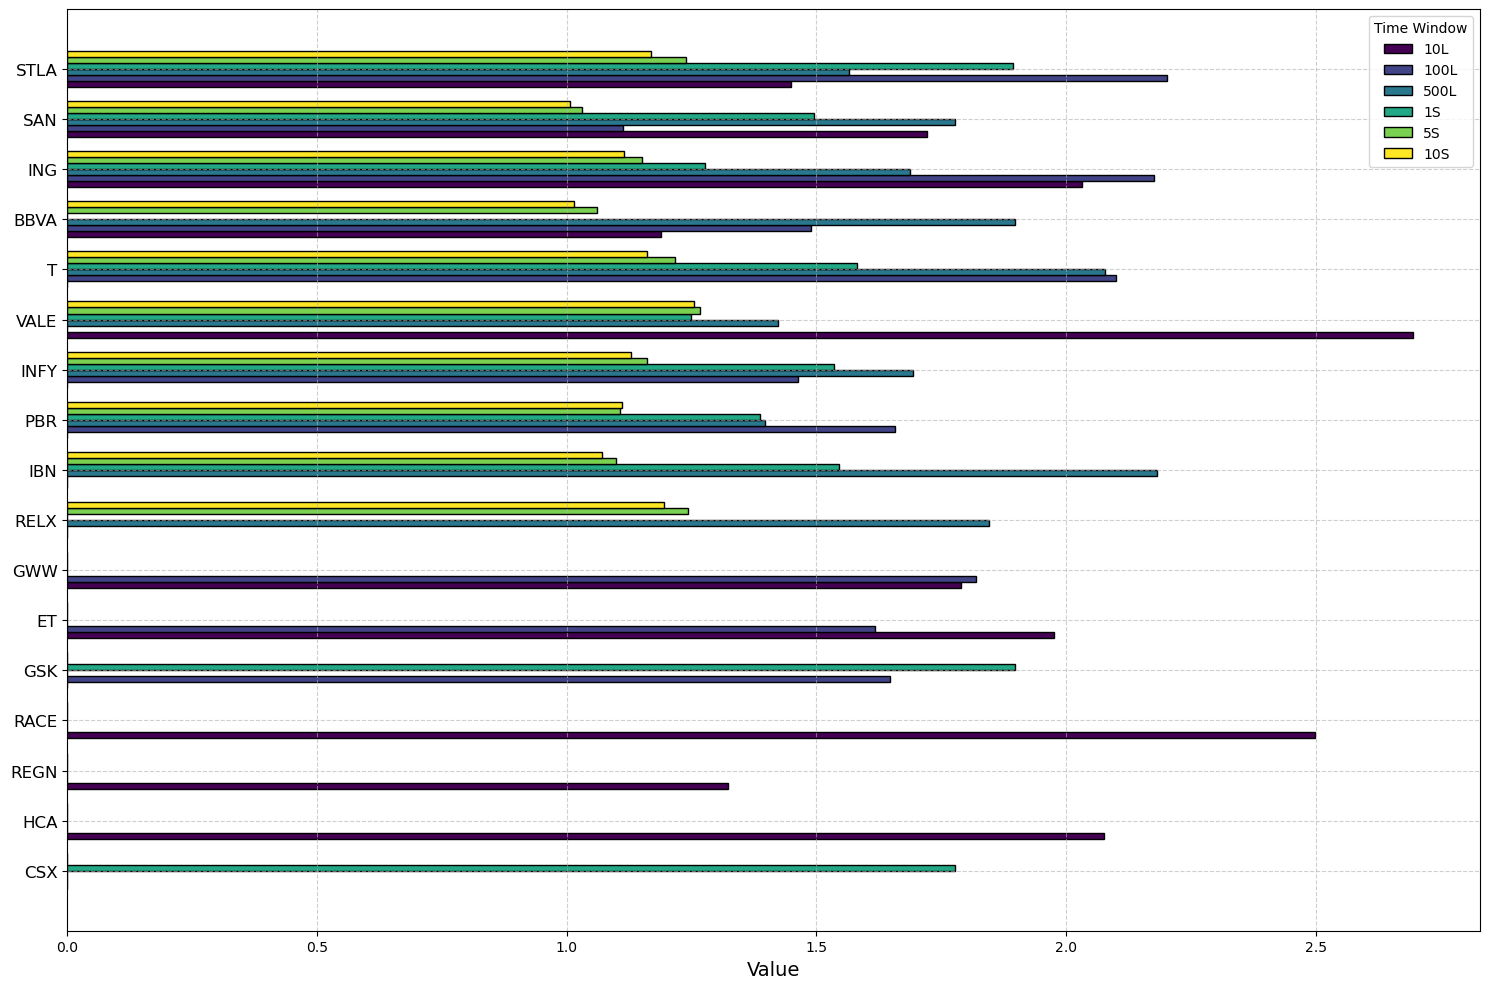

In [39]:
plot_ticker_values_combined_lower(flipped_bottom_10_tickers)

In [7]:

# find the top 5 tickers for the each column:
top_5_tickers_10L = holder_for_tickers.nlargest(5, '0,01').iloc[:, 0]
top_5_tickers_10L = top_5_tickers_10L.index.tolist()


top_5_tickers_100L = holder_for_tickers.nlargest(5, '0,1').iloc[:, 0]
top_5_tickers_100L = top_5_tickers_100L.index.tolist()


top_5_tickers_500L = holder_for_tickers.nlargest(5, '0,5').iloc[:, 0]
top_5_tickers_500L = top_5_tickers_500L.index.tolist()


top_5_tickers_1S = holder_for_tickers.nlargest(5, '1').iloc[:, 0]
top_5_tickers_1S = top_5_tickers_1S.index.tolist()


top_5_tickers_5S = holder_for_tickers.nlargest(5, '5').iloc[:, 0]
top_5_tickers_5S = top_5_tickers_5S.index.tolist()


top_5_tickers_10S = holder_for_tickers.nlargest(5, '10').iloc[:, 0]
top_5_tickers_10S = top_5_tickers_10S.index.tolist()

button_5_tickers_10L = holder_for_tickers.nsmallest(5, '0,01').iloc[:, 0]
button_5_tickers_10L = button_5_tickers_10L.index.tolist()

button_5_tickers_100L = holder_for_tickers.nsmallest(5, '0,1').iloc[:, 0]
button_5_tickers_100L = button_5_tickers_100L.index.tolist()

button_5_tickers_500L = holder_for_tickers.nsmallest(5, '0,5').iloc[:, 0]
button_5_tickers_500L = button_5_tickers_500L.index.tolist()

button_5_tickers_1S = holder_for_tickers.nsmallest(5, '1').iloc[:, 0]
button_5_tickers_1S = button_5_tickers_1S.index.tolist()

button_5_tickers_5S = holder_for_tickers.nsmallest(5, '5').iloc[:, 0]
button_5_tickers_5S = button_5_tickers_5S.index.tolist()

button_5_tickers_10S = holder_for_tickers.nsmallest(5, '10').iloc[:, 0]
button_5_tickers_10S = button_5_tickers_10S.index.tolist()



In [8]:
import pandas as pd

first_time = ['0,01', '0,1', '0,5', '1', '5', '10']
time = ['10L', '100L', '500L', '1S', '5S', '10S']
top_5 = [top_5_tickers_10L, top_5_tickers_100L, top_5_tickers_500L, top_5_tickers_1S, top_5_tickers_5S, top_5_tickers_10S]
button_5 = [button_5_tickers_10L, button_5_tickers_100L, button_5_tickers_500L, button_5_tickers_1S, button_5_tickers_5S, button_5_tickers_10S]
holder_for_decile_list_top = []

def closest_value(input):
    # Adjust the input to the closest higher multiple of 250
    return int(input + (200 - input % 200))

for i, x, a in zip(first_time, time, top_5):
    file_path = f'/Users/jensknudsen/Desktop/result/{i}/predictions_depth5_time{x}_window5_predicted.csv'
    label_df_new = pd.read_csv(file_path)
    val_procent = 0.2
    num_samples = len(label_df_new) * val_procent
    train_samples = closest_value(num_samples)
    val_df = label_df_new[:train_samples]
    test_df = label_df_new[train_samples:]

    combined_decile_list = []

    # Group by 'Time' and process each group
    for time, group in test_df.groupby('Time'):
        # Assign deciles based on 'predicted_return'
        group['Decile'] = pd.qcut(group['predicted_return'], 10, labels=False, duplicates='drop')
        
        # Filter group where the tickers are in the top_5 list
        group = group[group['Ticker'].isin(a)]
        
        # Ensure 'Ticker' column exists before setting it as the index
        if 'Ticker' in group.columns:
            group = group.set_index('Ticker')

            # Append the decile value to a list for each ticker in the top_5 list
            for_a = []
            for ticker in a:
                if ticker in group.index:
                    listtt = group.loc[ticker]['Decile'].tolist()
                    #combined_decile_list.append(group.loc[ticker]['Decile'].tolist())
                for_a.append(group.loc[ticker]['Decile'].tolist())
        combined_decile_list.append(for_a)
    holder_for_decile_list_top.append(combined_decile_list)


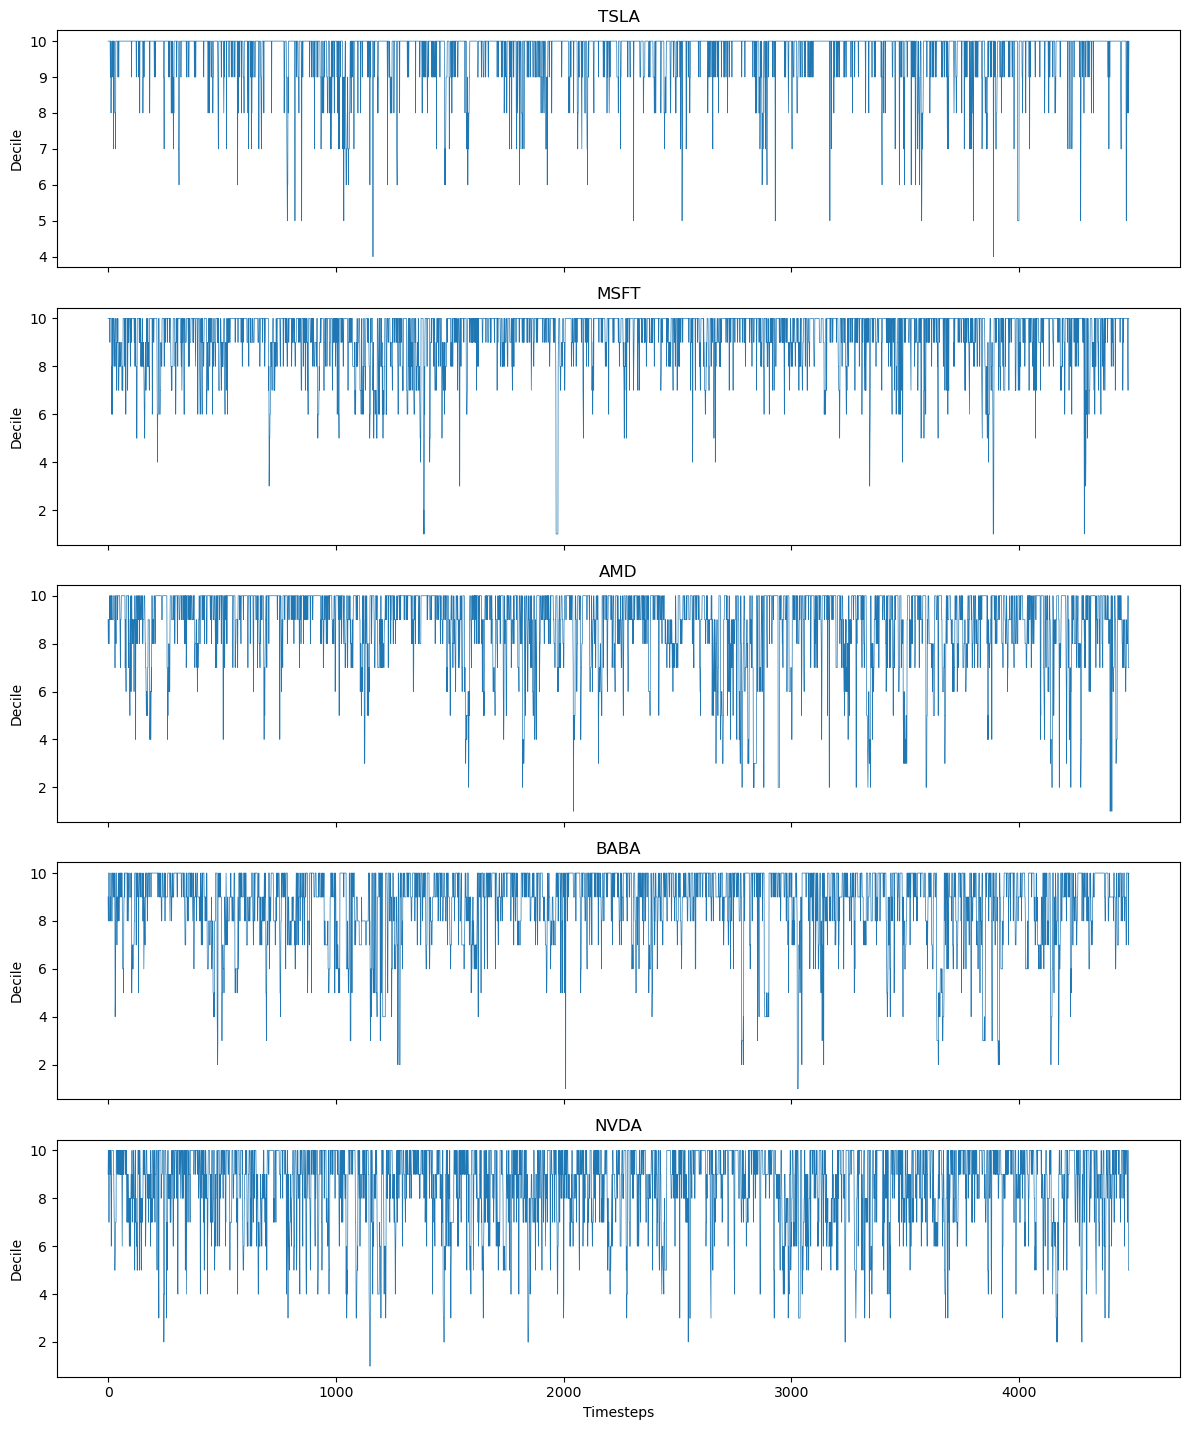

In [9]:
import seaborn as sns
# make a dataframe from holder_for_decile_list[0]
holder_for_decile_list_100L_top = pd.DataFrame(holder_for_decile_list_top[1])

# define the columns as top_5_tickers_100L reversed
holder_for_decile_list_100L_top.columns = top_5_tickers_100L

# add 1 to all the values in the dataframe
holder_for_decile_list_100L_done_top = holder_for_decile_list_100L_top + 1

holder_for_decile_list_100L_done_top.reset_index(inplace=True)

# Create the subplot layout
fig, axs = plt.subplots(5, 1, figsize=(12, 15), sharex=True)

# Add each stock's price movement to its respective subplot
for i, stock in enumerate(holder_for_decile_list_100L_done_top.columns[1:]):  # Skip the 'index' column
    sns.lineplot(data=holder_for_decile_list_100L_done_top, x='index', y=stock, ax=axs[i], linewidth=0.5)
    axs[i].set_title(stock)
    axs[i].set_ylabel('Decile')
    if i == len(holder_for_decile_list_100L_done_top.columns[1:]) - 1:
        axs[i].set_xlabel('Timesteps')

# Improve spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()

In [10]:
import pandas as pd

first_time = ['0,01', '0,1', '0,5', '1', '5', '10']
time = ['10L', '100L', '500L', '1S', '5S', '10S']
top_5 = [top_5_tickers_10L, top_5_tickers_100L, top_5_tickers_500L, top_5_tickers_1S, top_5_tickers_5S, top_5_tickers_10S]
button_5 = [button_5_tickers_10L, button_5_tickers_100L, button_5_tickers_500L, button_5_tickers_1S, button_5_tickers_5S, button_5_tickers_10S]
holder_for_decile_list_button = []

def closest_value(input):
    # Adjust the input to the closest higher multiple of 250
    return int(input + (200 - input % 200))

for i, x, a in zip(first_time, time, button_5):
    file_path = f'/Users/jensknudsen/Desktop/result/{i}/predictions_depth5_time{x}_window5_predicted.csv'
    label_df_new = pd.read_csv(file_path)
    val_procent = 0.2
    num_samples = len(label_df_new) * val_procent
    train_samples = closest_value(num_samples)
    val_df = label_df_new[:train_samples]
    test_df = label_df_new[train_samples:]

    combined_decile_list = []

    # Group by 'Time' and process each group
    for time, group in test_df.groupby('Time'):
        # Assign deciles based on 'predicted_return'
        group['Decile'] = pd.qcut(group['predicted_return'], 10, labels=False, duplicates='drop')
        
        # Filter group where the tickers are in the top_5 list
        group = group[group['Ticker'].isin(a)]
        
        # Ensure 'Ticker' column exists before setting it as the index
        if 'Ticker' in group.columns:
            group = group.set_index('Ticker')

            # Append the decile value to a list for each ticker in the top_5 list
            for_a = []
            for ticker in a:
                if ticker in group.index:
                    listtt = group.loc[ticker]['Decile'].tolist()
                    #combined_decile_list.append(group.loc[ticker]['Decile'].tolist())
                for_a.append(group.loc[ticker]['Decile'].tolist())
        combined_decile_list.append(for_a)
    holder_for_decile_list_button.append(combined_decile_list)


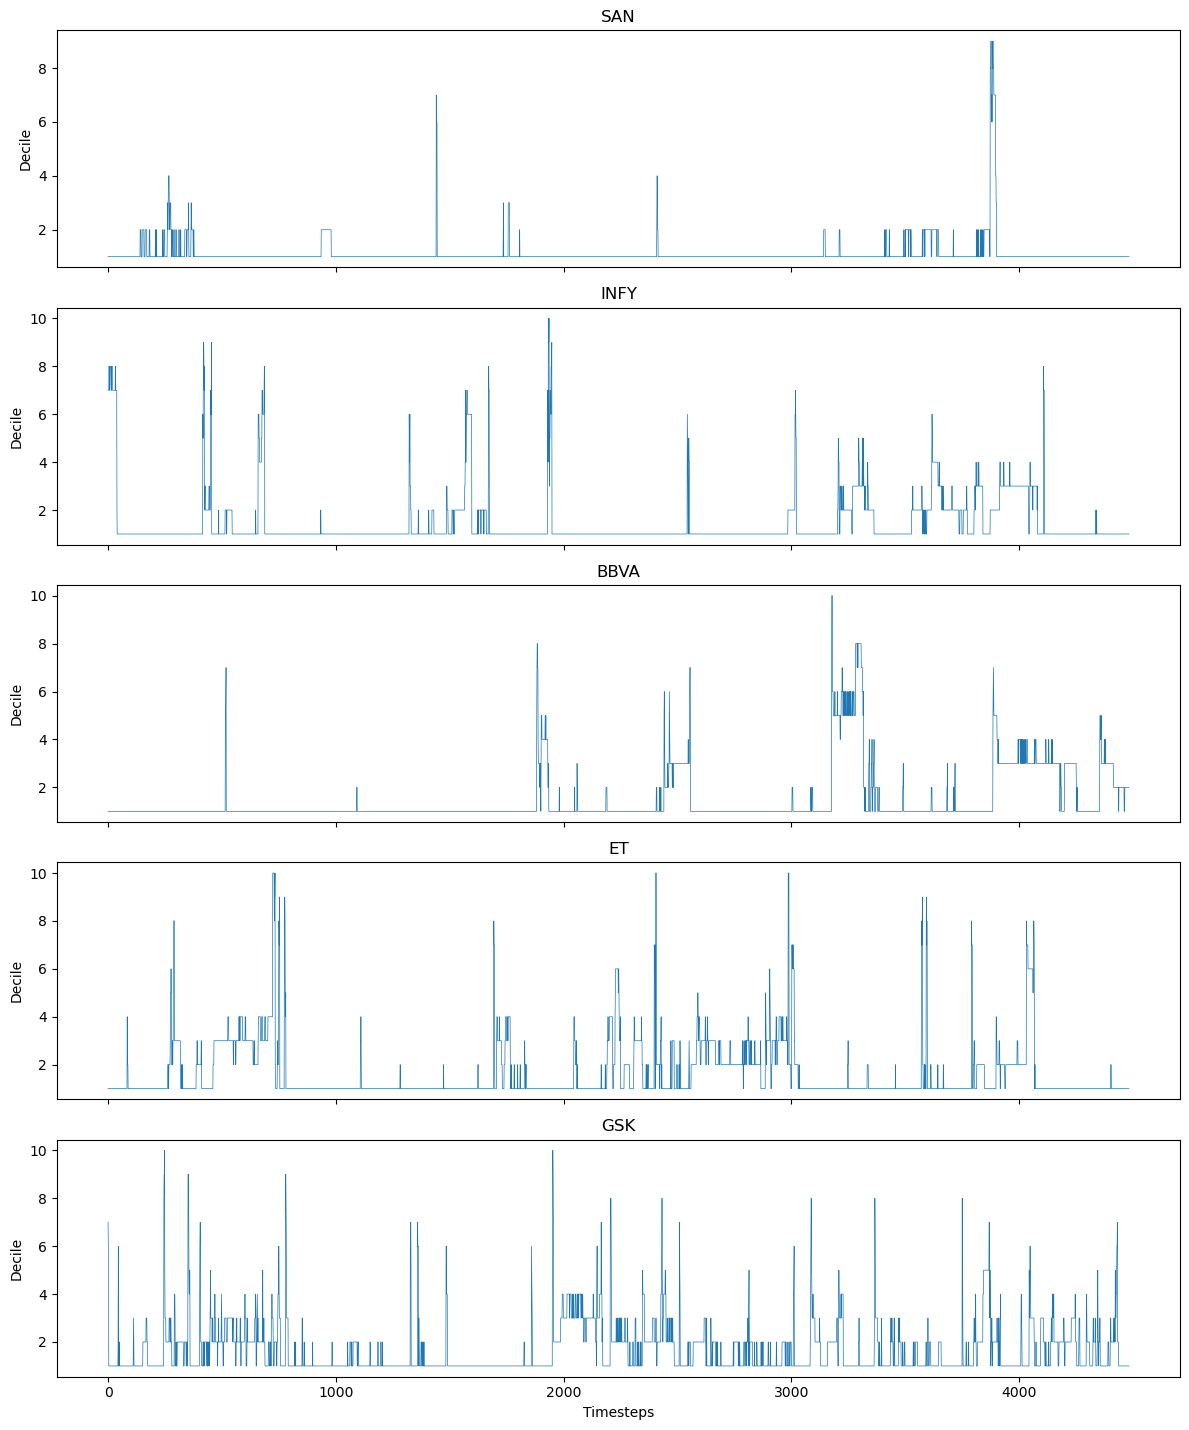

In [11]:
import seaborn as sns
# make a dataframe from holder_for_decile_list[0]
holder_for_decile_list_100L_button = pd.DataFrame(holder_for_decile_list_button[1])

# define the columns as button_5_tickers_100L reversed
holder_for_decile_list_100L_button.columns = button_5_tickers_100L

# add 1 to all the values in the dataframe
holder_for_decile_list_100L_done_button = holder_for_decile_list_100L_button + 1

holder_for_decile_list_100L_done_button.reset_index(inplace=True)

# Create the subplot layout
fig, axs = plt.subplots(5, 1, figsize=(12, 15), sharex=True)

# Add each stock's price movement to its respective subplot
for i, stock in enumerate(holder_for_decile_list_100L_done_button.columns[1:]):  # Skip the 'index' column
    sns.lineplot(data=holder_for_decile_list_100L_done_button, x='index', y=stock, ax=axs[i], linewidth=0.5)
    axs[i].set_title(stock)
    axs[i].set_ylabel('Decile')
    if i == len(holder_for_decile_list_100L_done_button.columns[1:]) - 1:
        axs[i].set_xlabel('Timesteps')

# Improve spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()

TypeError: 'AxesSubplot' object is not subscriptable

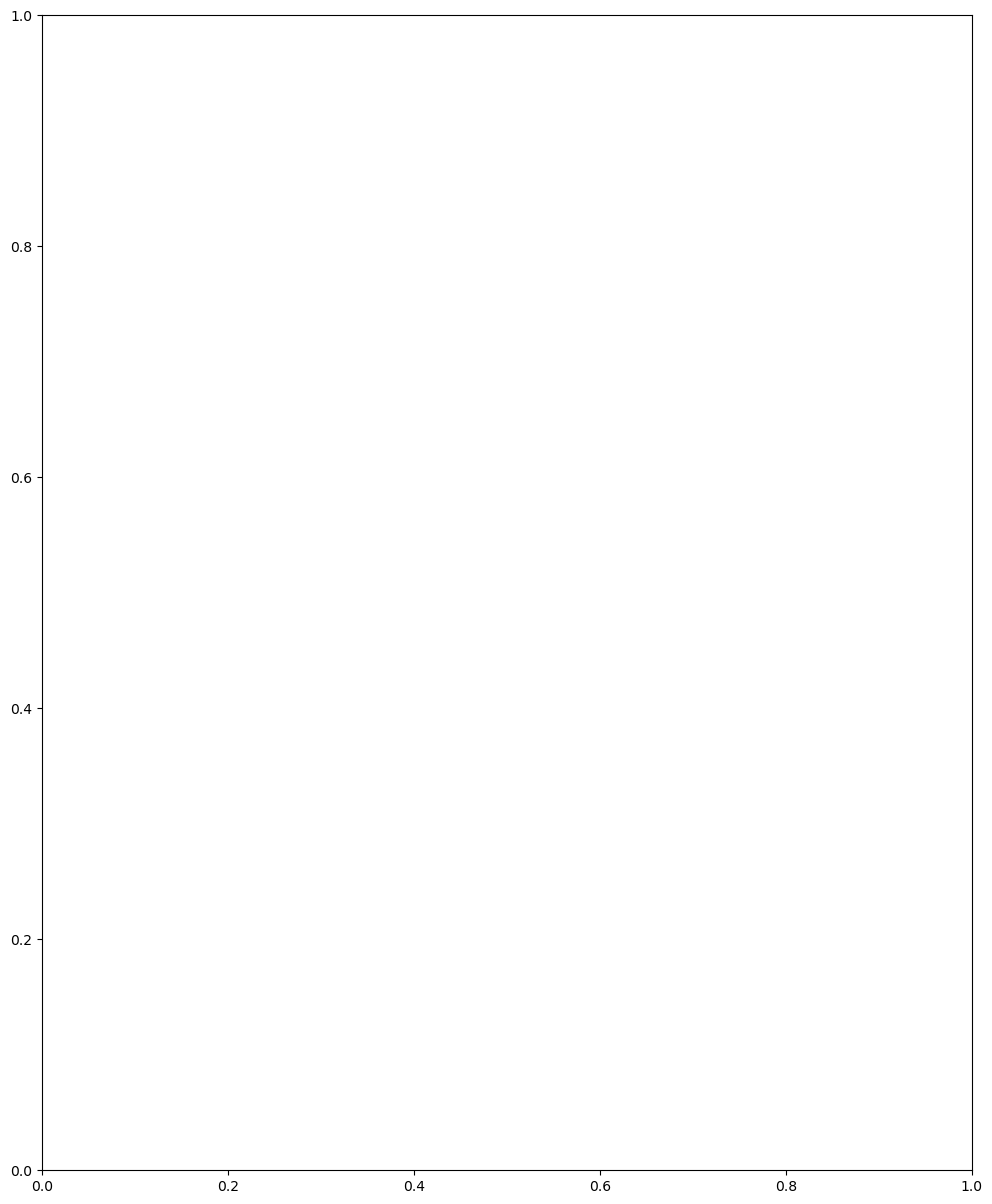

In [24]:
# combine two dataframes based on the index
combined_df = pd.concat([holder_for_decile_list_100L_done_top, holder_for_decile_list_100L_done_button], axis=1)


#select only the first two in top_5_tickers_100L
top_2_tickers_100L = holder_for_tickers.nlargest(2, '0,1').iloc[:, 1]
top_2_tickers_100L = top_2_tickers_100L.index.tolist()
button_2_tickers_100L = holder_for_tickers.nsmallest(2, '0,1').iloc[:, 1]
button_2_tickers_100L = button_2_tickers_100L.index.tolist()

# combine the two lists: 
tickers_100L = top_2_tickers_100L + button_2_tickers_100L

# select only the columns in combined_df that are in tickers_100L and the index too
combined_df = combined_df[tickers_100L]
combined_df.reset_index(inplace=True)
combined_df


# Create the subplot layout
fig, axs = plt.subplots(1, 4, figsize=(12, 15), sharex=True)

# Add each stock's price movement to its respective subplot
for i, stock in enumerate(combined_df.columns[1:]):  # Skip the 'index' column
    sns.lineplot(data=combined_df, x='index', y=stock, ax=axs[i], linewidth=0.5)
    axs[i].set_title(stock)
    axs[i].set_ylabel('Decile')
    if i == len(combined_df.columns[1:]) - 1:
        axs[i].set_xlabel('Timesteps')

# Improve spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()

In [ ]:
# delete the last 3 columns in combined_df 
combined_df = combined_df.drop(columns=['MSFT', 'SAN', 'INFY'])

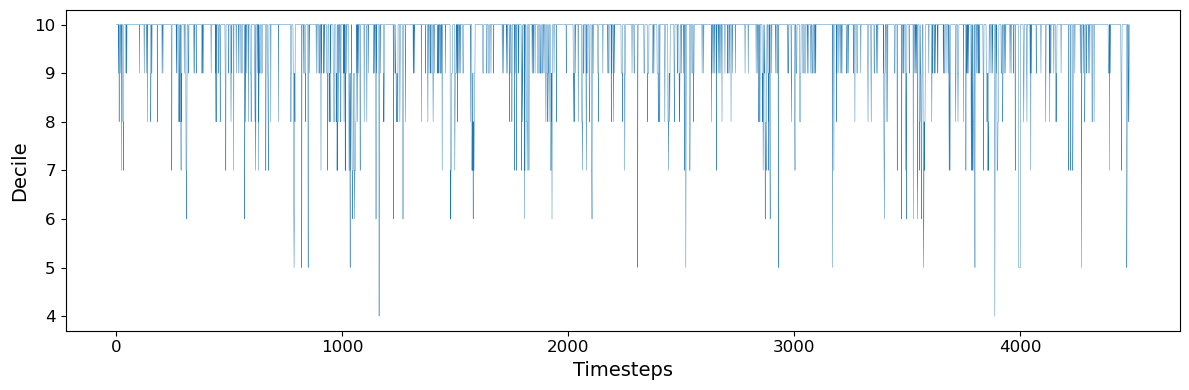

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Iterate through each stock and create a separate plot
for i, stock in enumerate(combined_df.columns[1:]):  # Skip the 'index' column
    plt.figure(figsize=(12, 4))
    sns.lineplot(data=combined_df, x='index', y=stock, linewidth=0.3)
    plt.title(stock)
    # delete the title
    plt.title('')
    # make the x and y asix names bigger
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    # also the labels bigger 
    plt.xlabel('Timesteps', fontsize=14)
    plt.ylabel('Decile', fontsize=14)
    plt.ylabel('Decile')
    if i == len(combined_df.columns[1:]) - 1:
        plt.xlabel('Timesteps')
    plt.tight_layout()
    plt.show()


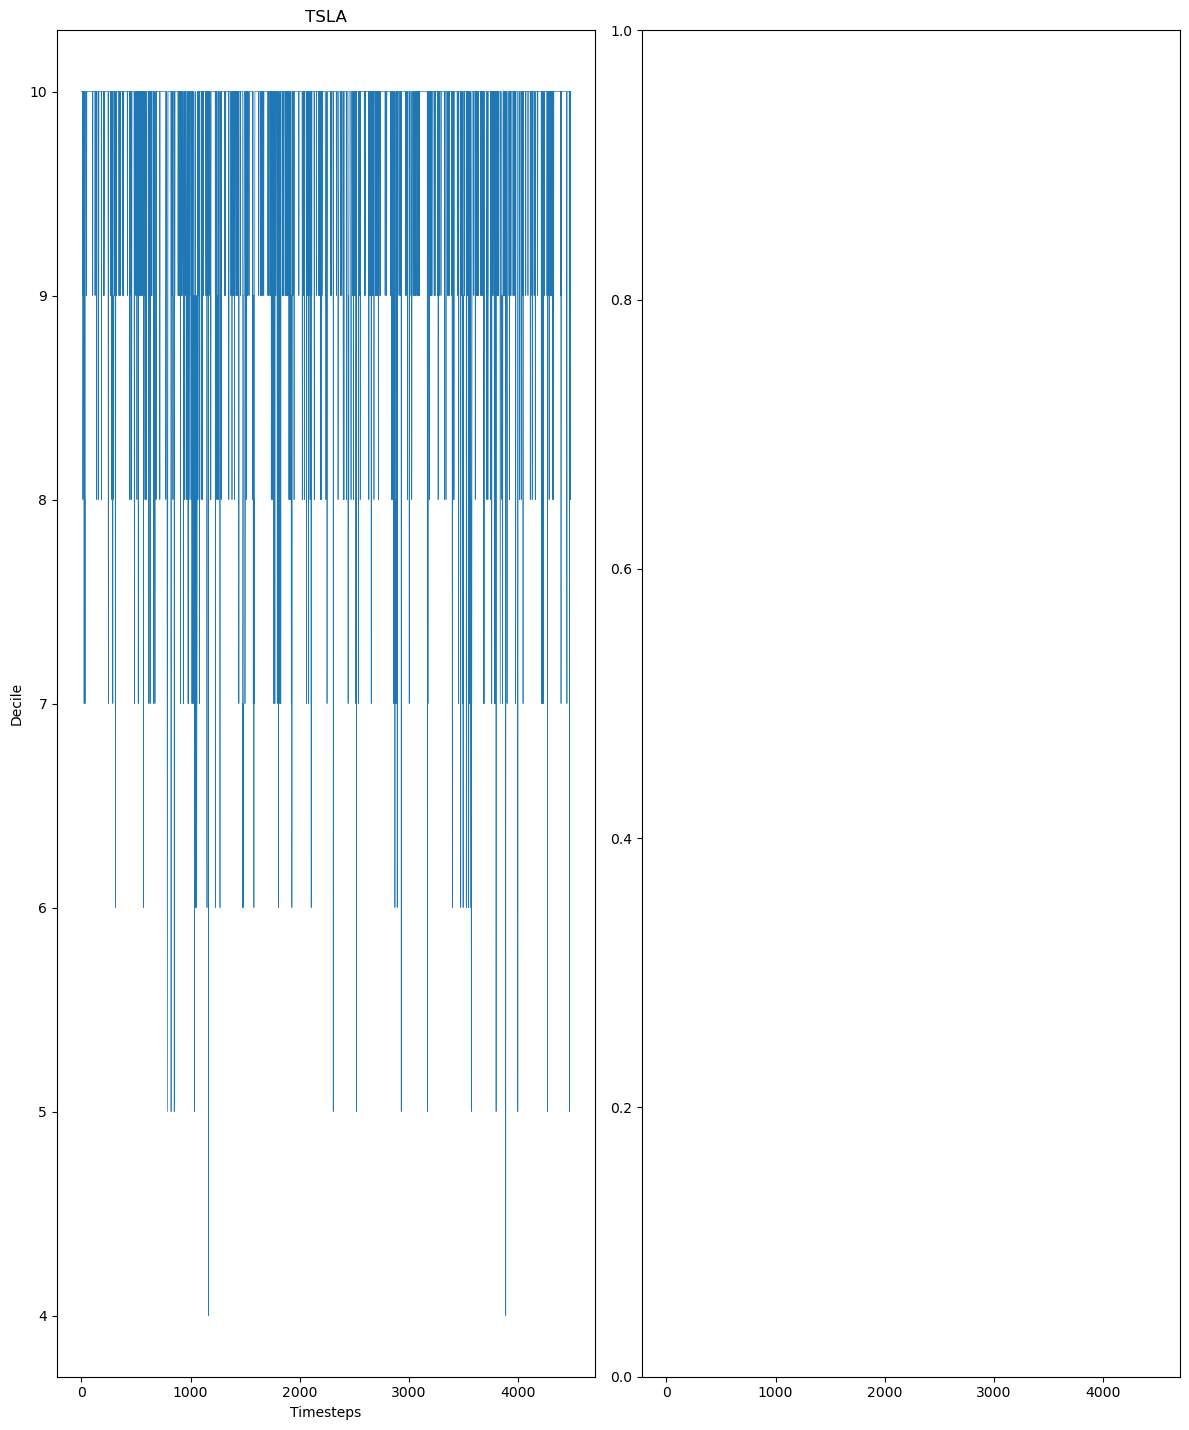

In [29]:

# Create the subplot layout
fig, axs = plt.subplots(1, 2, figsize=(12, 15), sharex=True)

# Add each stock's price movement to its respective subplot
for i, stock in enumerate(combined_df.columns[1:]):  # Skip the 'index' column
    sns.lineplot(data=combined_df, x='index', y=stock, ax=axs[i], linewidth=0.5)
    axs[i].set_title(stock)
    axs[i].set_ylabel('Decile')
    if i == len(combined_df.columns[1:]) - 1:
        axs[i].set_xlabel('Timesteps')

# Improve spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()